<a href="https://colab.research.google.com/github/bururaru/Food-101-with-VGGNET16/blob/master/lastest_main_RMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Check if GPU is enabled
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

1.13.1
/device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [13]:
import os
import shutil

# source_path = "/gdrive/My Drive/food-101.tar"
# target_path = "/content"

# if not os.path.exists(target_path):
#     
shutil.copy("/gdrive/My Drive/food-101.tar.gz", "/content")

'/content/food-101.tar.gz'

In [14]:
cd /content

/content


In [0]:
!tar xzvf food-101.tar.gz

In [16]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [0]:
import os
os.listdir('food-101/images')

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

In [0]:
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [0]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

In [0]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [22]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find food-101/train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [23]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find food-101/test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [24]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# for layer in vgg_conv.layers:
#   print(layer, layer.trainable)
  
model = models.Sequential()
 
model.add(vgg_conv)

model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dropout_1 (Dropout)         

In [0]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

model = keras.models.load_model('best_model_101class.hdf5')
model.summary()

In [25]:
from google.colab import files
import os
import shutil


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 128
val_batchsize = 64
train_dir = 'food-101/train'
validation_dir = 'food-101/test'
n_classes = 101
image_size = 224
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
#               metrics=['acc'])

# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#               metrics=['acc'])

checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log', separator='/', append=True)

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,
      callbacks=[csv_logger, checkpointer])
 
# Save the model
model.save('best_model_101class.hdf5')

shutil.copy("/content/history.log", "/gdrive/My Drive")
shutil.copy("/content/best_model_101class.hdf5", "/gdrive/My Drive")

# source_path = "/content/best_model_101class.hdf5"
# target_path = "/gdrive/My Drive"

# if not os.path.exists(target_path):
#     shutil.copy(source_path, target_path)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
592/591 [==============================] - 1398s 2s/step - loss: 4.1989 - acc: 0.1644 - val_loss: 3.0746 - val_acc: 0.3312

Epoch 00001: val_loss improved from inf to 3.07456, saving model to best_model_101class.hdf5
Epoch 2/20
592/591 [==============================] - 1331s 2s/step - loss: 3.0775 - acc: 0.3445 - val_loss: 2.6685 - val_acc: 0.4170

Epoch 00002: val_loss improved from 3.07456 to 2.66850, saving model to best_model_101class.hdf5
Epoch 3/20
592/591 [==============================] - 1326s 2s/step - loss: 2.6262 - acc: 0.4348 - val_loss: 2.1807 - val_acc: 0.5154

Epoch 00003: val_loss improved from 2.66850 to 2.18069, saving model to best_model_101class.hdf5
Epoch 4/20
592/591 [==============================] - 1328s 2s/step - loss: 2.3504 - acc: 0.4839 - val_loss: 2.0489 - val_acc: 0.5440

Epoch 00004: val_loss improved from

'/gdrive/My Drive/best_model_101class.hdf5'

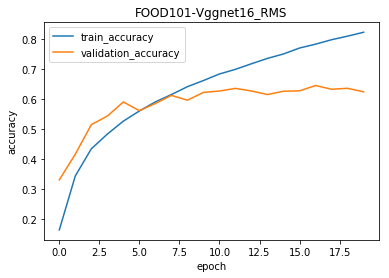

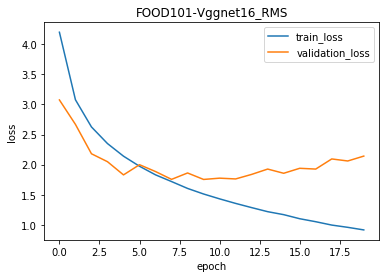

In [26]:
import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Vggnet16_RMS')
plot_loss(history,'FOOD101-Vggnet16_RMS')